In [2]:
from PIL import Image
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import laserbeamsize as lbs
import mayavi.mlab as mlab
from pint import UnitRegistry
ureg = UnitRegistry()

from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import LogNorm

In [30]:
# SMALL_SIZE = 10
# MEDIUM_SIZE = 12
# BIGGER_SIZE = 20

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
          'figure.titlesize':14,
         'axes.labelsize': 14,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

plt.rcParams.update(params)
# plt.rcParams['font.size'] = 16     # Set some basic plotting parameters
# plt.rcParams["figure.figsize"] = [8.00, 4.00]

In [3]:
# image = cv2.imread("Planoconvex focus 100mm/IR3.png")
# # xdim = len(image[:,1]) #2048
# # ydim = len(image[1,:]) #2448


In [4]:
# gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# x1, y1 = np.mgrid[0:len(gray):1, 0:len(gray[1]):1]

# gray2 = gray[800:1100,1100:1600]
# x2, y2 = np.mgrid[0:len(gray2):1, 0:len(gray2[1]):1]

# fig = plt.figure(figsize=(14, 8)) #
# ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.plot_surface(x1, y1, gray, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax.plot_surface(x2, y2, gray2, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# ax.set_title('Beam Profile - 3D')
# fig.savefig("3Dbeamprof.png")

In [12]:
class BeamRead:
    def __init__(self, image_path, background_path=0, pixel_size_um = 3.45, lambda1 = 1030e-9):
        
        """
        Bakcground, pixel size and wavelength are optional,
        Standard pixelsize is of Bresser MikroCam II 5MP HIS from:
            
            https://www.bresser.de/Mikroskopie/Mikroskopkameras/USB-Kameras/BRESSER-MikroCamII-5MP-HIS-Mikroskopkamera.html?mtm_campaign=Doofinder&mtm_kwd=5914510&mtm_source=German&mtm_medium=OnSite&mtm_cid=Germany&mtm_group=SiteSearch
        
        Standard Wavelength: 1030 nm
        
        """
        
        image = cv2.imread(image_path)
        
        self.xdim = len(image)
        self.ydim = len(image[1])
        
        if background_path != 0:
            bg = cv2.imread(background_path)
            if type(bg) == None:
                raise ValueError('Invalid filename background file')
#             else:
#                 image=lbs.subtract_image(image, bg)
                image = image - bg
        #image = lbs.subtract_threshold(image, 35)
        self.im = image
        self.gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.pixel_size_um = pixel_size_um
        self.lambda1 = lambda1
        
  
    def PlotImage(self): 
        
        """Plots image"""
        fig, ax = plt.subplots(figsize=(13, 7))
        ax.imshow(self.gray[939:980,1290:1450])             
        #ax.set_xlim(0, self.ydim)
        #ax.set_ylim(0, self.xdim)
        
        #ax.set_xticks(np.arange(-self.ydim/2, self.ydim/2, step=1/self.ydim))
        
        
        fig
        fig.savefig("image_100mm.png")
    
    
    def PlotImage3D(self):
        
        """Display 3D interactive Image, note: takes a while before the plot shows"""
        x, y = np.mgrid[0:len(self.gray):1, 0:len(self.gray[1]):1]
        mlab.figure(bgcolor=(1, 1, 1))
        mlab.surf(x, y, self.gray)
        mlab.show()
        
    def GaussianFit(self):
        
        """Calculated beam radius and Rayleigh length and divergence of beam
        Assuming perfect Gaussian"""
        
        x, y, dx, dy, phi = lbs.beam_size(self.gray)
        
        dx = dx*self.pixel_size_um
        dy = dy*self.pixel_size_um
        
        w0 = ((dx+dy)/2) * 1e-6
        zR=lbs.z_rayleigh(w0,self.lambda1)
        theta = w0/zR
              
        beam_waist = w0 * ureg.meter
        rayleigh_length = zR * ureg.meter
        divergence = theta * ureg.rad

        print('Beam waist:', beam_waist.to_compact())
        print('Rayleigh length:', rayleigh_length.to_compact())
        print('Divergence:', divergence.to_compact())

        

    def PlotGaussianFit(self):
        #lbs.beam_size_and_plot(self.gray[300:1400,1000:2000], pixel_size = self.pixel_size_um, units='µm', cmap='gist_ncar')
        
        """Plot Gaussian fit"""
        
        #lbs.beam_size_plot(self.gray[939:980,1290:1450], pixel_size = self.pixel_size_um, units='µm', cmap='gist_ncar')
        #lbs.beam_size_and_plot(self.gray[800:2100,:], pixel_size = self.pixel_size_um, units='µm', cmap='gist_ncar')
        lbs.beam_size_plot(self.gray, pixel_size = self.pixel_size_um, units='µm')
        
        plt.tight_layout()
        
    
    def M2(self):
        
        """Calculates M^2 factor"""
        
        x, y, dx, dy, phi = lbs.beam_size(self.gray)
        dx = dx*self.pixel_size_um
        dy = dy*self.pixel_size_um
        z  = 0
        lbs.M2_diameter_plot(z, dx = dx*1e-6, lambda0 = self.lambda1, dy=dy*1e-6)
                
        plt.show()
        
    def draw_beam_figure(self):
        
        lbs.draw_beam_figure()
        plt.savefig("axes.png")

In [6]:


# p3= BeamRead("Planoconvex focus 100mm/IR3.png", "Planoconvex focus 100mm/bg_lightson.png", lambda1 = 1030e-9)
# #p3.PlotImage()
# # p3.PlotImage3D()
# p3.PlotGaussianFit()
# plt.savefig("gaussianfit_100mm_frac.png", bbox_inches = 'tight')
# p3.GaussianFit()

# #p3.draw_beam_figure()


In [7]:


# p4= BeamRead("Beam Expander profiling/Magnification measurement/be_inv_max_lowexptime.png", lambda1 = 1030e-9)
# p4.PlotGaussianFit()
# plt.savefig("gaussianfit_be_inv_max_lowexptime.png", bbox_inches = 'tight')


In [8]:
# p5= BeamRead("Beam Expander profiling/Magnification measurement/be_inv_min_lowexptime.png", lambda1 = 1030e-9)
# p5.PlotGaussianFit()
# plt.savefig("gaussianfit_be_inv_min_lowexptime.png", bbox_inches = 'tight')


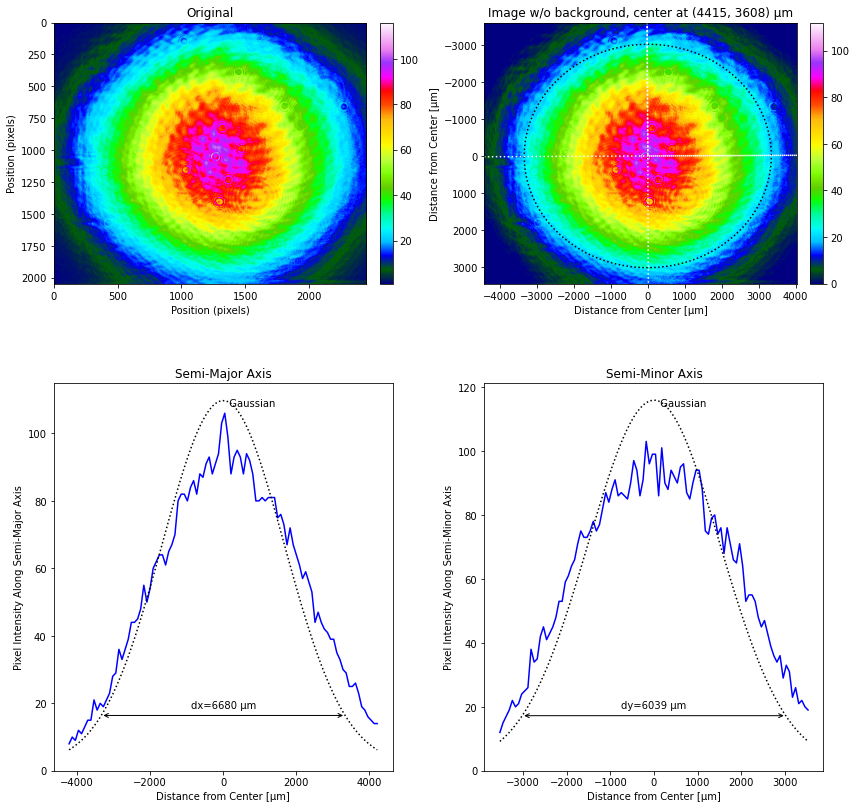

In [14]:
p6= BeamRead("Beam Expander profiling/Magnification measurement/be_max.png", lambda1 = 1030e-9)
p6.PlotGaussianFit()
plt.savefig("gaussianfit_be_max.png", bbox_inches = 'tight')

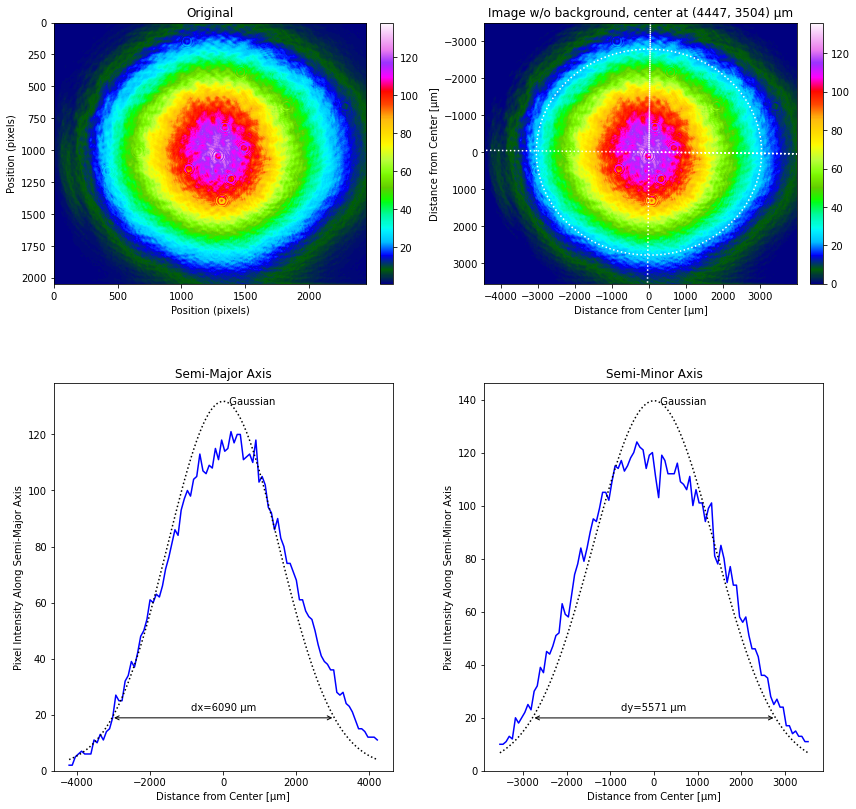

In [13]:
p7= BeamRead("Beam Expander profiling/Magnification measurement/be_min.png", lambda1 = 1030e-9)
p7.PlotGaussianFit()
plt.savefig("gaussianfit_be_min.png", bbox_inches = 'tight')

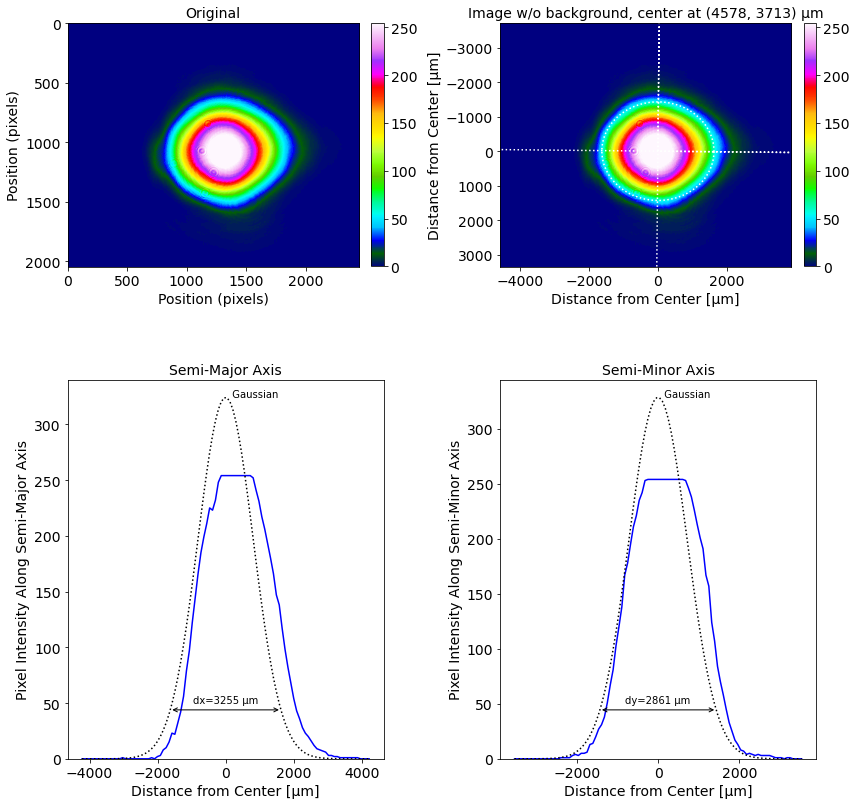

In [14]:
p8= BeamRead("Beam Expander profiling/Magnification measurement/nobe.png", "Planoconvex focus 100mm/bg_lightson.png", lambda1 = 1030e-9)
p8.PlotGaussianFit()
plt.savefig("gaussianfit_nobe.png", bbox_inches = 'tight')

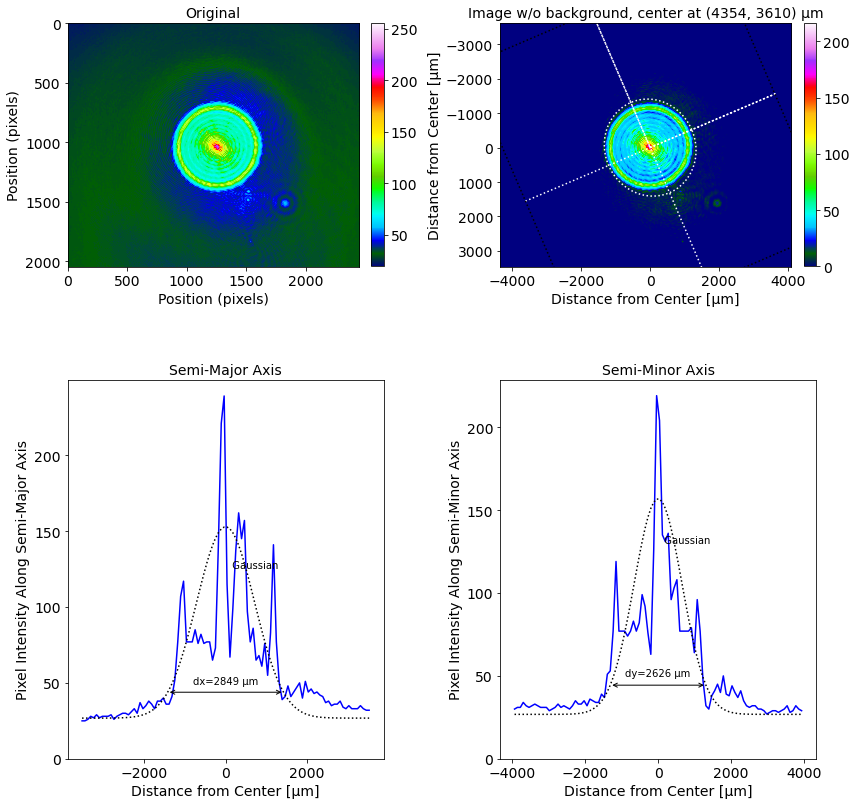

In [456]:

p9= BeamRead("Axicon_BE/filter_be_axicon_635nm.png", lambda1 = 1030e-9)
p9.PlotGaussianFit()
plt.savefig("gaussianfit_be1.png", bbox_inches = 'tight')

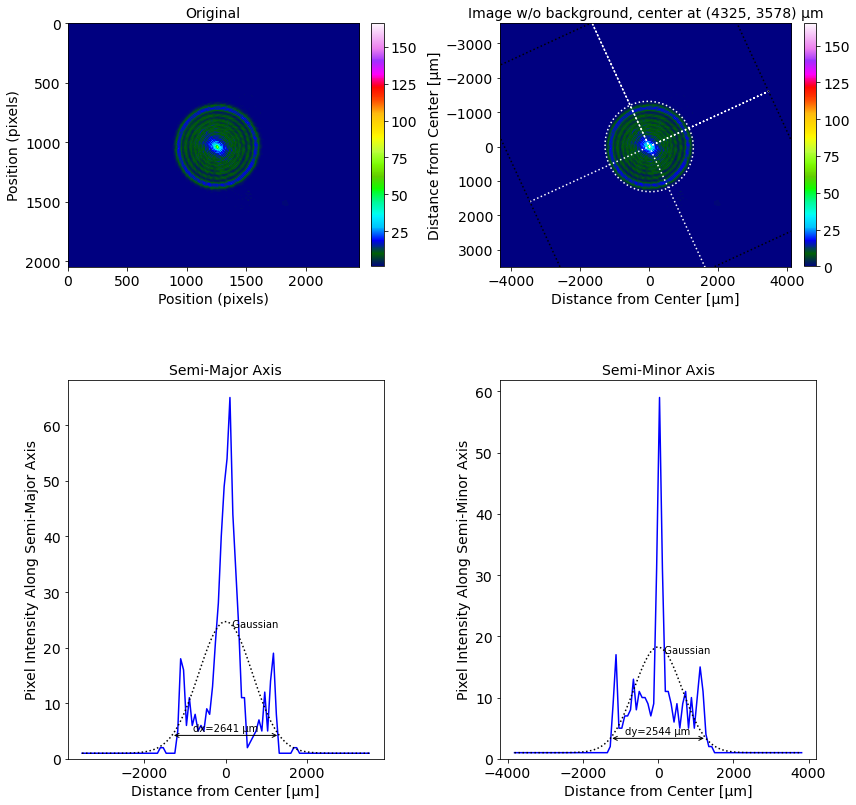

In [460]:
p10= BeamRead("Axicon_BE/filter_be_axicon_635nm_et2_gain121.png", lambda1 = 1030e-9)
p10.PlotGaussianFit()
plt.savefig("gaussianfit_be2.png", bbox_inches = 'tight')

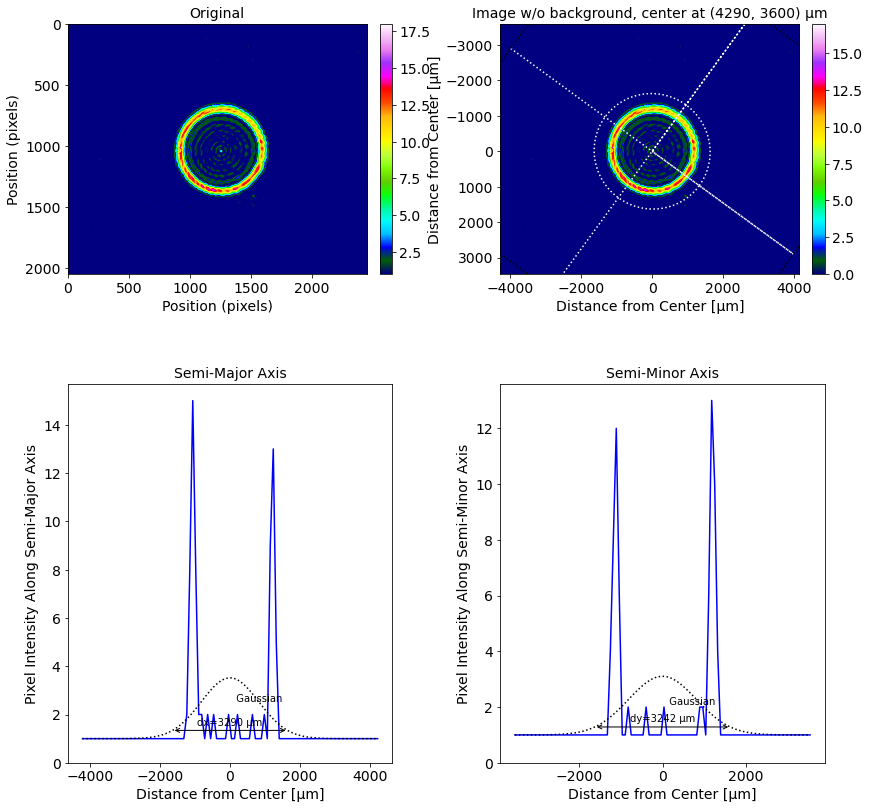

In [467]:
p11= BeamRead("Axicon_BE/filter_be_iris_axicon_635nm_et2_gain121.png", lambda1 = 1030e-9)
p11.PlotGaussianFit()
plt.savefig("gaussianfit_be4.png", bbox_inches = 'tight')

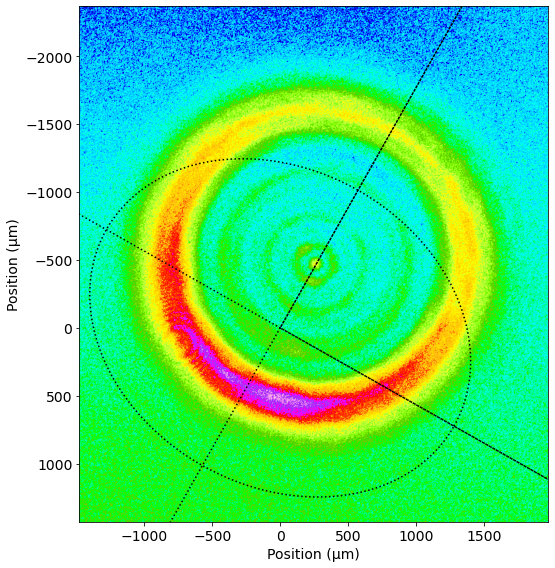

In [490]:
p12= BeamRead("Axicon_BE/filter_be_iris_axicon_1030nm_2.png", lambda1 = 1030e-9)
p12.PlotGaussianFit()
plt.savefig("gaussianfit_be6.png", bbox_inches = 'tight')

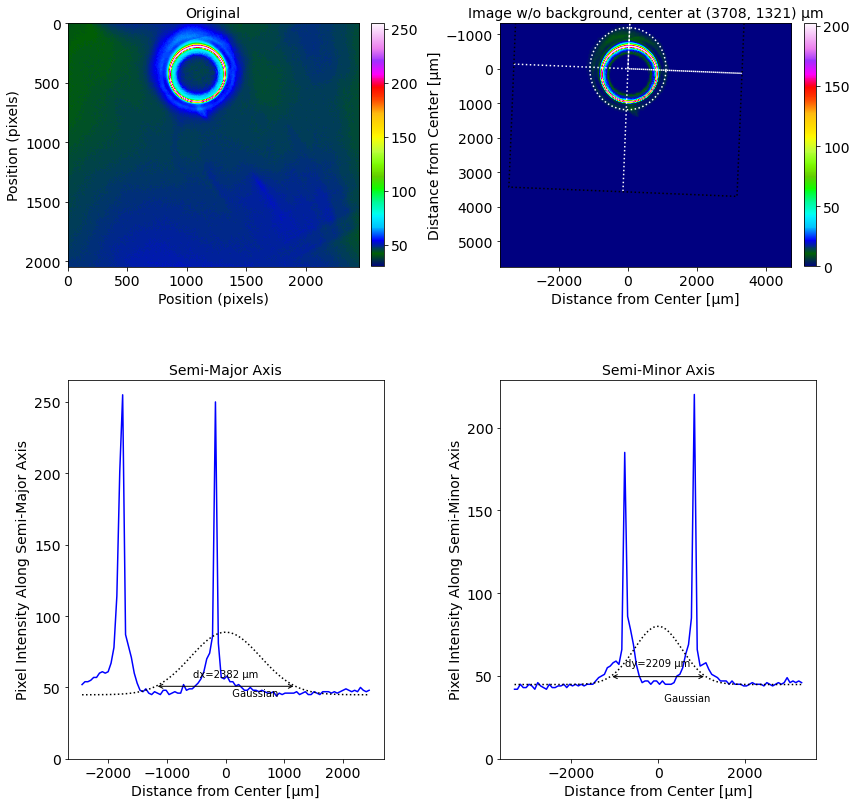

In [494]:
p13= BeamRead("Axicon_BE/filter_be_min38.5_iris0mm34.5_axicon15.5_1030nm.png", lambda1 = 1030e-9)
p13.PlotGaussianFit()
plt.savefig("gaussianfit_be_axicon_planoconvex3.png", bbox_inches = 'tight')

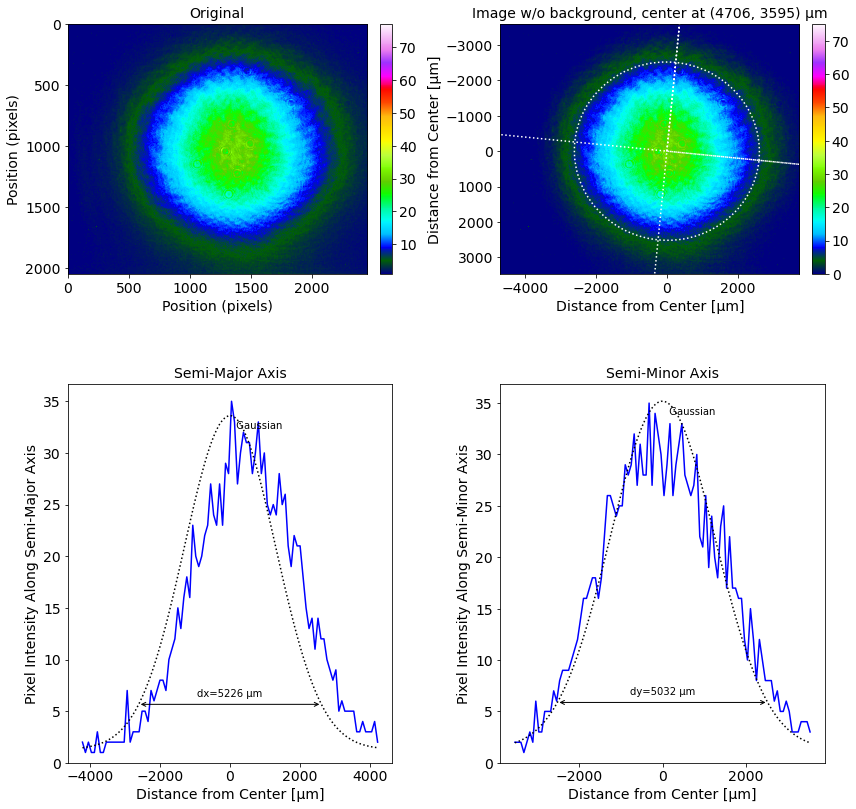

In [496]:
p14= BeamRead("Beam Expander profiling/Magnification measurement/be_minimum_0,02uj.png", lambda1 = 1030e-9)
p14.PlotGaussianFit()
plt.savefig("be_minimum_0,02uj.png", bbox_inches = 'tight')

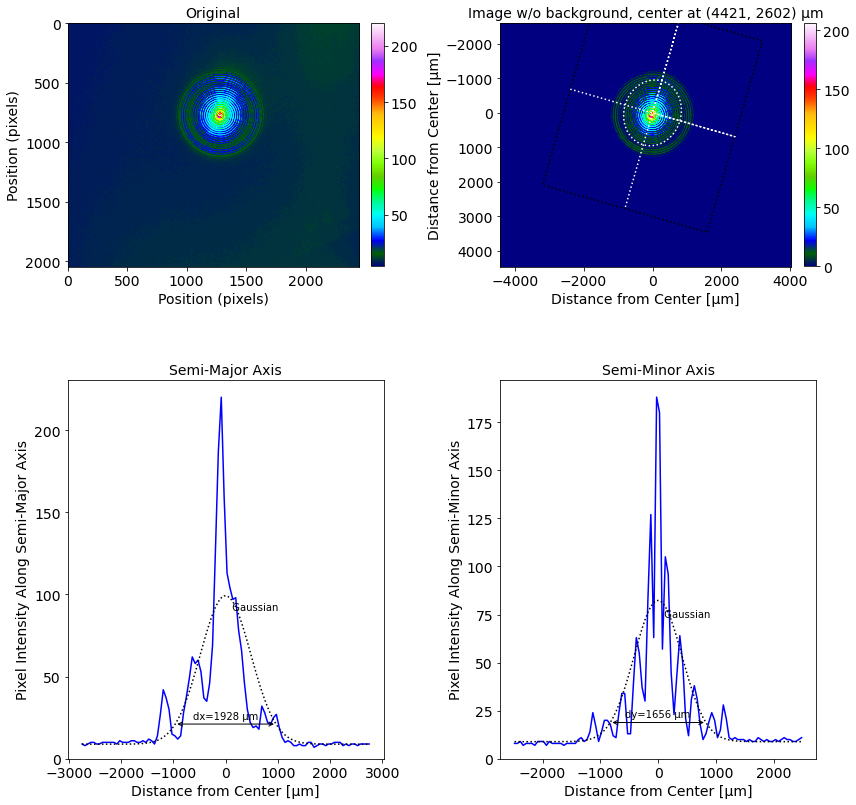

In [542]:

p15= BeamRead("Axicon_BE/filter_be_axicon_1030nm_L24.5.png", lambda1 = 1030e-9)
p15.PlotGaussianFit()
plt.savefig("filter_be_axicon_1030nm_L24.5.png", bbox_inches = 'tight')

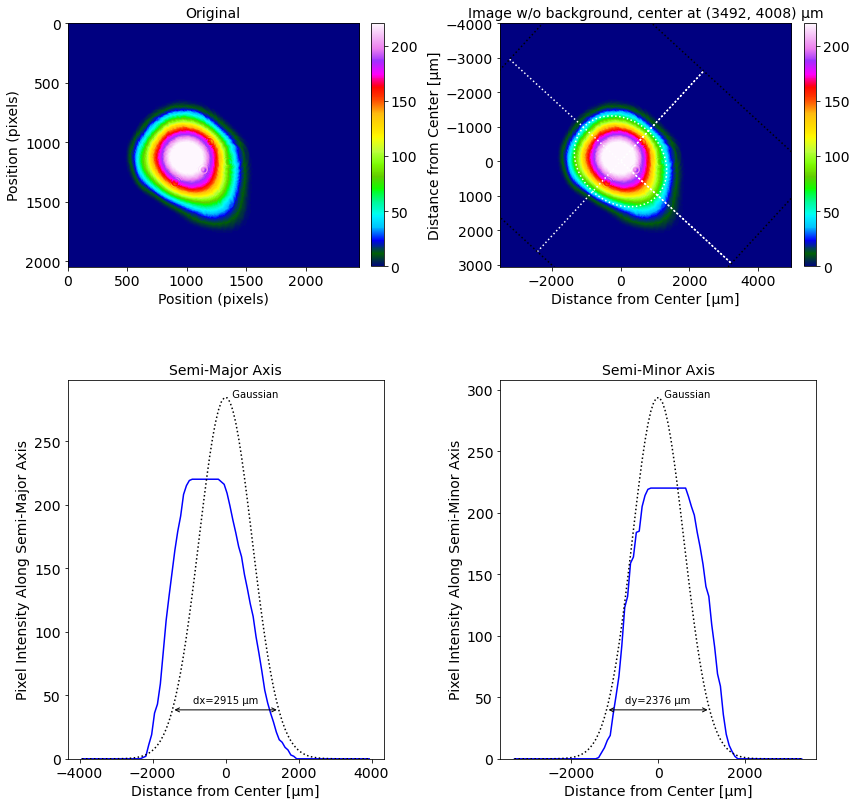

In [546]:
p16= BeamRead("Beam Expander profiling/be_inversed_maximum - Copy.png", lambda1 = 1030e-9)
p16.PlotGaussianFit()
plt.savefig("nobe0,02uj.png", bbox_inches = 'tight')

5083.48325823591
0.0003934310193231653
[4.8712901  4.77890987 4.6866497  4.59451684 4.50251909 4.41066491
 4.31896345 4.22742467 4.13605936 4.04487927 3.95389722 3.8631272
 3.77258452 3.68228594 3.59224988 3.50249657 3.41304833 3.32392979
 3.23516818 3.14679372 3.05883997 2.97134427 2.88434831 2.79789872
 2.71204774 2.62685407 2.54238377 2.45871142 2.3759213  2.29410895
 2.21338278 2.13386607 2.05569918 1.97904206 1.90407706 1.83101202
 1.76008359 1.69156055 1.62574708 1.5629855  1.50365801 1.44818672
 1.39703105 1.35068145 1.30964828 1.27444516 1.24556652 1.22346029
 1.20849817 1.20094721 1.20094721 1.20849817 1.22346029 1.24556652
 1.27444516 1.30964828 1.35068145 1.39703105 1.44818672 1.50365801
 1.5629855  1.62574708 1.69156055 1.76008359 1.83101202 1.90407706
 1.97904206 2.05569918 2.13386607 2.21338278 2.29410895 2.3759213
 2.45871142 2.54238377 2.62685407 2.71204774 2.79789872 2.88434831
 2.97134427 3.05883997 3.14679372 3.23516818 3.32392979 3.41304833
 3.50249657 3.59224988 3.

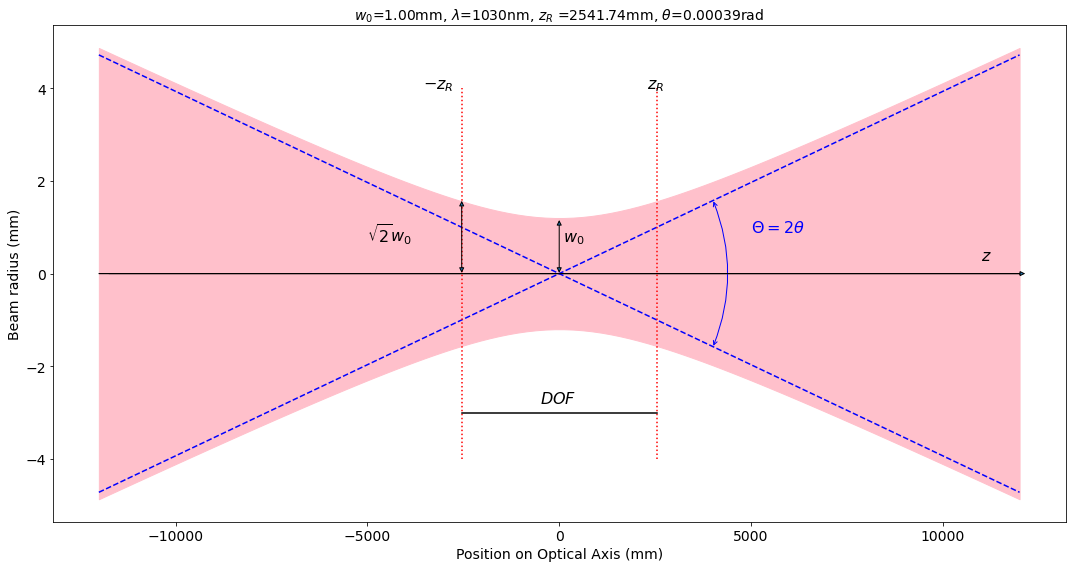

In [38]:
w0=1                 # radius of beam waist [mm]
z0=0                   # z-axis position of beam waist [mm]
lambda0=1.030/1000       # again in mm
zR =  lbs.z_rayleigh(w0,lambda0)/1.2 #(np.pi*w0**2)/(lambda0*1.2) # Rayleigh Distance
print(2*zR)

theta = w0/zR #rad
print(theta)
z = np.linspace(-12000,12000,100)
r = lbs.beam_radius(w0, lambda0, z, z0=z0)*1.2
print(r)
plt.fill_between(z, -r, r, color='pink')

plt.plot(z,theta*(z-z0),'--b')
plt.plot(z,-theta*(z-z0),'--b')
plt.plot([zR+z0,zR+z0],[-4,4],':r')
plt.plot([-zR+z0,-zR+z0],[-4,4],':r')
plt.plot([-zR,zR],[-3,-3],color="black")
plt.arrow(-12000,0,24000, 0,
          head_width = 0.033,
          width = 0.001,
          ec ='black')



plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.2fmm, $\lambda$=%.0fnm, $z_R$ =%.2fmm, $\\theta$=%.5frad"%(w0,1e6*lambda0, zR, theta))
plt.annotate('$z_R$',xy=(0.9*(zR+z0),4),fontsize=16)
plt.annotate('$-z_R$',xy=(1.4*(-zR+z0),4),fontsize=16)
plt.annotate('$z$',xy=(11000,0.3),fontsize=16)
plt.annotate('$w_0$',xy=(100,0.7),fontsize=16)
plt.annotate('$\sqrt{2}w_0$',xy=(-5000,0.7),fontsize=16)
plt.annotate('$DOF$',xy=(-500,-2.8),fontsize=16)

plt.annotate(r'$\Theta=2\theta$',xy=(5000,1),fontsize=16,va='center',color='blue')
plt.annotate('',xy=(4000,1.6),xytext=(4000,-1.6),arrowprops=dict(connectionstyle="arc3,rad=0.2", arrowstyle="<->",color='blue'))
plt.annotate('', xy=(-zR,np.sqrt(2)*w0+0.2), xytext=(-zR,-0.2), va='center',
             multialignment='up',
             arrowprops={'arrowstyle': '<|-|>', 'lw': 1, 'ec': 'black', 'shrinkA': 10})
plt.annotate('', xy=(0,w0+0.2), xytext=(0,-0.2), va='center',
             multialignment='up',
             arrowprops={'arrowstyle': '<|-|>', 'lw': 1, 'ec': 'black', 'shrinkA': 10})
plt.annotate('', xy=(12200,0), xytext=(-12000,0), va='center',
             multialignment='left',
             arrowprops={'arrowstyle': '-|>', 'lw': 1, 'ec': 'black', 'shrinkA': 10})
plt.tight_layout()
plt.savefig("laserbeam.png", bbox_inches = 'tight')
plt.show()

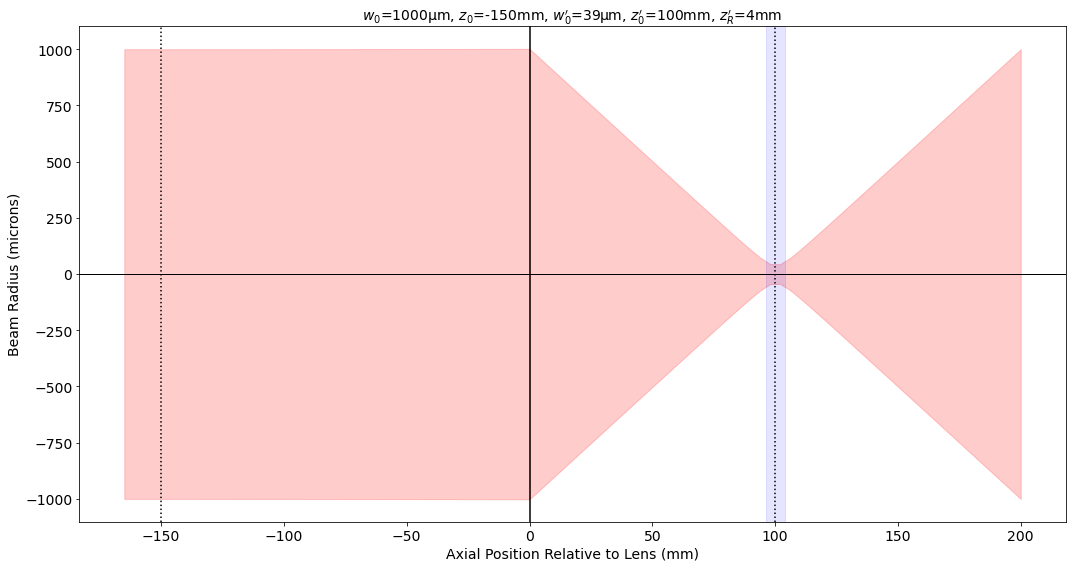

In [39]:
lambda0 = 1030e-9  # wavelength of light [m]
w0 = 1000e-6         # radius at beam waist [m]
f  = 100e-3         # focal length of lens [m]

lbs.M2_focus_plot(w0, lambda0, f, z0=-150e-3, M2=1.2)
plt.tight_layout()
plt.savefig("laserbeamfocus100mm.png", bbox_inches = 'tight')
plt.show()

In [46]:
'''Laser beam parameters'''
w0_mm = 1 #mm
wavel_mm = 1030/(10**6) #mm
pulse_energy_J = 10**-6 #joule
m2= 1.2

#calculations
lbeam_divergence_half_angle_rad = (m2 * wavel_mm)/ (np.pi*w0_mm)
lbeam_2zR_mm = 2*((np.pi * w0_mm**2) / (wavel_mm * m2))
fluence_J_cm2 = pulse_energy_J/(np.pi*(w0_mm*0.1)**2)

lbeam_2zR_mm

5083.48325823591

In [26]:
axicon_dof_mm =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))
axicon_dof_mm

array([  5.09295818,  31.6299508 ,  58.16694341,  84.70393603,
       111.24092865, 137.77792126, 164.31491388, 190.8519065 ,
       217.38889911, 243.92589173, 270.46288434, 296.99987696,
       323.53686958, 350.07386219, 376.61085481, 403.14784743,
       429.68484004, 456.22183266, 482.75882528, 509.29581789])

In [76]:
central_lobe_diameter_mm = 2*2.405/ ((2*np.pi/(800*10**-6))*np.sin(math.radians(3)))
central_lobe_diameter_mm

i=ref_index*np.sin(math.radians(a_angle_deg))
print(i,math.asin(i))

beta_angle_rad = abs(math.radians(a_angle_deg)-math.asin(ref_index*math.asin(math.radians(a_angle_deg))))
#print(beta_angle_rad)

central_lobe_diameter_mm = 2*2.405/ ((2*np.pi/(1030*10**-6))*np.sin(beta_angle_rad))
print(central_lobe_diameter_mm)
axicon_dof_mm =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))

axicon_dof_mm_2 = incoming_beam_radius_mm/np.tan(beta_angle_rad)

#print(axicon_dof_mm, axicon_dof_mm_2)

0.025305989334061092 0.025308691076190087
0.10034519450647884


In [116]:
import math
incoming_beam_radius_mm=np.linspace(0.04, 4, 10)#np.array(( 0.05, 0.125, 0.14,0.20,0.25,0.3,1,3,4,5,6,7,8)) #mm
L_mm = np.linspace(10, 250, 10)#np.array((20, 50, 100, 120, 150, 200, 220, 250, 300, 320, 350, 400, 420))
wavel_mm = 1030/(10**6)
m2 =1.2
pulse_energy_J = 10**-6 #joule
ref_index = 1.45
a_angle_deg = 1 #degrees
'''Axicon Calculations'''

def axicon(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg):
    dof = np.zeros(len(incoming_beam_radius_mm))
    index = []
    diameter = np.zeros(len(incoming_beam_radius_mm)*len(L_mm))
    fluence = np.zeros(len(incoming_beam_radius_mm)*len(L_mm))
    for j in range(len(incoming_beam_radius_mm)):
        dof[j] =  incoming_beam_radius_mm[j]/((ref_index-1)*math.radians(a_angle_deg))
        for i in range(len(L_mm)):
            if  dof[j] < L_mm[i]:
                index[j] = index.append("BB")
                L_mm_bessel = L_mm[i]
                kappa = 2.405
                z_bb = dof[j]
                beta_angle_rad = abs(math.radians(a_angle_deg)-math.asin(ref_index*math.asin(math.radians(a_angle_deg))))
                central_lobe_diameter_mm = 2*kappa/ ((2*np.pi/wavel_mm)*np.sin(beta_angle_rad))
                diameter[i]= central_lobe_diameter_mm
                central_lobe_fluence_J_cm2 = (4*pulse_energy_J)/((central_lobe_diameter_mm/2)*z_bb*np.tan(beta_angle_rad))
                fluence[i] = central_lobe_fluence_J_cm2
            elif dof[j] >= L_mm[i] :
                index[j] = index.append("Ring")
                L_mm_ring = L_mm[i]
                ring_thickness_mm = incoming_beam_radius_mm[i]
                ring_diameter_mm = 2*L_mm_ring*np.tan((ref_index-1)*math.radians(a_angle_deg))
                diameter[i]= ring_diameter_mm
                ring_radius_mm = ring_diameter_mm/2
                ring_fluence_J_cm2 = pulse_energy_J/(np.pi*((ring_radius_mm**2-(ring_radius_mm-ring_thickness_mm))**2))
                fluence[i] = ring_fluence_J_cm2
            else:
                print("error")
    return incoming_beam_radius_mm, dof,  diameter, fluence, index

            
axicon(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg)
# len(a[4])

(array([0.04, 0.48, 0.92, 1.36, 1.8 , 2.24, 2.68, 3.12, 3.56, 4.  ]),
 array([  5.09295818,  61.11549815, 117.13803812, 173.16057808,
        229.18311805, 285.20565802, 341.22819799, 397.25073796,
        453.27327793, 509.29581789]),
 array([0.15708286, 0.5759705 , 0.99485813, 1.41374576, 1.8326334 ,
        2.25152103, 2.67040866, 3.0892963 , 3.50818393, 3.92707156,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.      

[  5.09295818  31.6299508   58.16694341  84.70393603 111.24092865
 137.77792126 164.31491388 190.8519065  217.38889911 243.92589173
 270.46288434 296.99987696 323.53686958 350.07386219 376.61085481
 403.14784743 429.68484004 456.22183266 482.75882528 509.29581789]
(array([  5.09295818,  31.6299508 ,  58.16694341,  84.70393603,
       111.24092865, 137.77792126, 164.31491388, 190.8519065 ,
       217.38889911, 243.92589173, 270.46288434, 296.99987696,
       323.53686958, 350.07386219, 376.61085481, 403.14784743,
       429.68484004, 456.22183266, 482.75882528, 509.29581789]), 2.042077213535733, array([0.04      , 0.24842105, 0.45684211, 0.66526316, 0.87368421,
       1.08210526, 1.29052632, 1.49894737, 1.70736842, 1.91578947,
       2.12421053, 2.33263158, 2.54105263, 2.74947368, 2.95789474,
       3.16631579, 3.37473684, 3.58315789, 3.79157895, 4.        ]), array([[8.42102654e-05, 4.36955302e-06, 1.39125581e-06, 6.74931798e-07,
        3.97231347e-07, 2.61358949e-07, 1.84917265e-07, 

ValueError: x and y must have same first dimension, but have shapes (20,) and (1, 20)

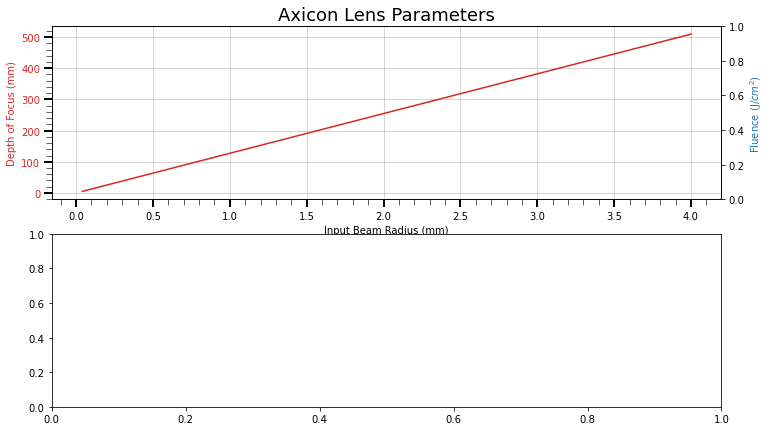

In [28]:


'''Axicon + Plano Convex Calculations'''
def axicon_plano_convex(incoming_beam_radius_mm, L_mm):
    pulse_energy_J = 10**-6 #joule
    ref_index = 1.45
    a_angle_deg = 1 #degrees
    pc_f_mm = 100 #mm
    
    axicon_pc_dof_mm =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))
    ring_diameter_mm = 2*L_mm*np.tan((ref_index-1)*math.radians(a_angle_deg))
    ring_radius_mm = ring_diameter_mm/2
    ring_thickness_mm = incoming_beam_radius_mm
    ring_fluence_J_cm2 = pulse_energy_J/(np.pi*((ring_radius_mm**2-(ring_radius_mm-ring_thickness_mm))**2))
    
    ax_pc_dof_mm = (8*wavel_mm*m2/np.pi)*((pc_f_mm/ring_diameter_mm)**2)
    return axicon_pc_dof_mm, ring_diameter_mm, ring_thickness_mm, ring_fluence_J_cm2


a =axicon(incoming_beam_radius_mm, L_mm)
print(a)


b = axicon_plano_convex(incoming_beam_radius_mm, L_mm)
#print(b)

# #fig1, [[ax1, ax3], [ax5, ax7]] = plt.subplots(2,2, figsize=(15, 7))
fig2, (ax1, ax3) = plt.subplots(2,1, figsize=(12, 7))

color = 'tab:red'
ax1.set_xlabel('Input Beam Radius (mm)')
ax1.set_ylabel('Depth of Focus (mm)', color=color)
ax1.set_title('Axicon Lens Parameters', fontsize=18)
ax1.plot(incoming_beam_radius_mm, a[0], label='Depth of Focus (DOF)', color=color)
#ax1.set_ylim(0, 1200)

ax1.grid()
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax1.tick_params(which='minor', length=6)
ax1.tick_params(axis='y', labelcolor=color)

#ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
#x3.append(ax1.twinx())
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
ax2.plot(incoming_beam_radius_mm, a[3], label='Ring Fluence', color=color)

ax2.grid()
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax2.tick_params(which='minor', length=6)
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:green'
ax3.set_xlabel('Distance from axicon to image/focused spot (mm)')
ax3.set_ylabel('Ring Diameter (mm)', color=color)
ax3.plot(L_mm, a[1],  label='Diameter of the generated ring shaped spot', color=color)

ax3.grid()
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax3.tick_params(which='minor', length=6)
ax3.tick_params(axis='y', labelcolor=color)

#ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
#x3.append(ax1.twinx())
#ax3.set_ylim(0, 10)
ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
ax4.plot(L_mm, a[3], label='Ring Fluence',color=color)

ax4.grid()
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax4.tick_params(which='minor', length=6)
ax4.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper center', bbox_to_anchor=(0.24, 0.98))
ax2.legend(loc='upper center', bbox_to_anchor=(0.2, 0.8))
ax3.legend(loc='upper center', bbox_to_anchor=(0.35, 0.98))
ax4.legend(loc='upper center', bbox_to_anchor=(0.2, 0.8))
fig2.tight_layout()  # otherwise the right y-label is slightly clipped
#fig2.savefig('axicon_calc.png')
plt.show()



# color = 'tab:red'
# ax5.set_xlabel('Input Beam Radius (mm)')
# ax5.set_ylabel('Depth of Focus (mm)', color=color)
# ax5.plot(incoming_beam_radius_mm, b[0], color=color)
# ax5.tick_params(axis='y', labelcolor=color)
# #ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
# #x3.append(ax1.twinx())
# ax6 = ax5.twinx() # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax6.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
# ax6.plot(incoming_beam_radius_mm, b[3], color=color)
# ax6.tick_params(axis='y', labelcolor=color)


# color = 'tab:green'
# ax7.set_xlabel('Distance from axicon to image/focused spot (mm)')
# ax7.set_ylabel('Ring Diameter (mm)', color=color)
# ax7.plot(L_mm, b[1], color=color)
# ax7.tick_params(axis='y', labelcolor=color)
# #ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
# #x3.append(ax1.twinx())
# ax8 = ax7.twinx() # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax8.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
# ax8.plot(L_mm, b[3], color=color)
# ax8.tick_params(axis='y', labelcolor=color)

# fig1.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()



In [581]:
import math
incoming_beam_radius_mm=np.linspace(0.001,8, 35)#np.array(( 0.05, 0.125, 0.14,0.20,0.25,0.3,1,3,4,5,6,7,8)) #mm
L_mm = np.linspace(10, 400, 35)#np.array((20, 50, 100, 120, 150, 200, 220, 250, 300, 320, 350, 400, 420))

'''Axicon Calculations'''

def axicon(incoming_beam_radius_mm, L_mm):
    pulse_energy_J = 10**-6 #joule
    ref_index = 1.45
    a_angle_deg = 170 #degrees
    axicon_dof_mm =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))
    axicon_ring_diameter_mm = 2*L_mm*np.tan((ref_index-1)*math.radians(a_angle_deg))
    axicon_ring_radius_mm = axicon_ring_diameter_mm/2
    axicon_ring_thickness_mm = incoming_beam_radius_mm
    axicon_ring_fluence_J_cm2 = pulse_energy_J/(np.pi*((axicon_ring_radius_mm**2-(axicon_ring_radius_mm-axicon_ring_thickness_mm))**2))
            
    return axicon_dof_mm, axicon_ring_diameter_mm, axicon_ring_thickness_mm, axicon_ring_fluence_J_cm2
axicon(400,10)
299*0.09

26.91

In [554]:

'''Axicon + Plano Convex Calculations'''
def axicon_plano_convex(incoming_beam_radius_mm, L_mm):
    pulse_energy_J = 10**-6 #joule
    ref_index = 1.45
    a_angle_deg = 1 #degrees
    pc_f_mm = 100 #mm
    
    axicon_pc_dof_mm =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))
    ring_diameter_mm = 2*L_mm*np.tan((ref_index-1)*math.radians(a_angle_deg))
    ring_radius_mm = ring_diameter_mm/2
    ring_thickness_mm = incoming_beam_radius_mm
    ring_fluence_J_cm2 = pulse_energy_J/(np.pi*((ring_radius_mm**2-(ring_radius_mm-ring_thickness_mm))**2))
    
    ax_pc_dof_mm = (8*wavel*m2/np.pi)*((pc_f_mm/ring_diameter_mm)**2)
    return axicon_pc_dof_mm, ring_diameter_mm, ring_thickness_mm, ring_fluence_J_cm2


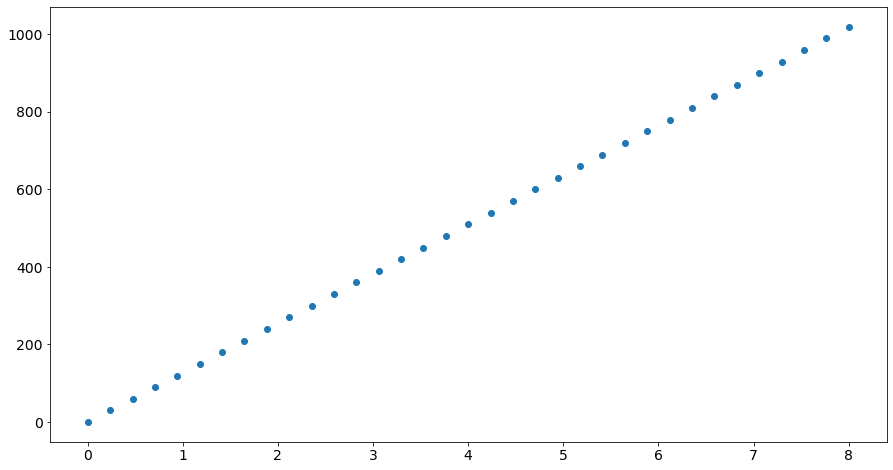

In [558]:
b = axicon_plano_convex(incoming_beam_radius_mm, L_mm)
b
plt.scatter(incoming_beam_radius_mm, b[0])

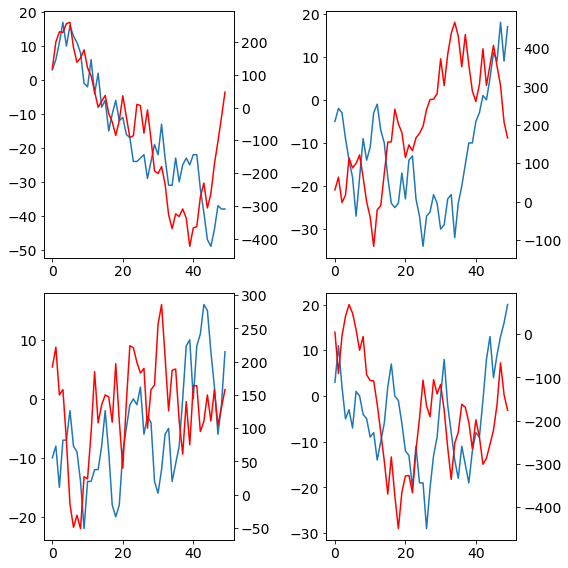

In [343]:
# create a figure with 4 subplot axes
fig, axes = plt.subplots(2,2, figsize=(8,8))

for ax_row in axes:
    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        ax2 = ax.twinx()
        # plot some data on each axis.
        ax.plot(np.arange(50), np.random.randint(-10,10, size=50).cumsum())
        ax2.plot(np.arange(50), 100+np.random.randint(-100,100, size=50).cumsum(), 'r-')

plt.tight_layout()
plt.show()


In [237]:
'''Plano Convex 100mm calculations'''
pc_f_mm = 100
pc_100_w0 = (2*wavel*m2/np.pi)*(pc_f_mm/2*w0_mm)
pc_100_dof_mm = (8*wavel*m2/np.pi)*((pc_f_mm/2*w0_mm)**2)

print(pc_100_w0,pc_100_dof_mm)

0.039343101932316535 7.868620386463307


7.73197803577682
0.010087974854440136


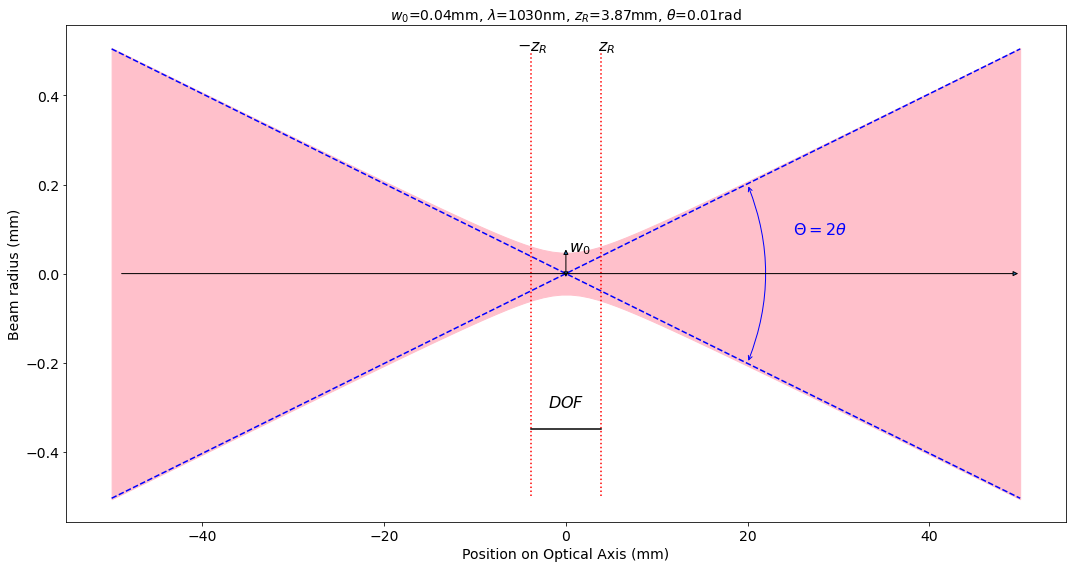

In [42]:
w0=0.039                   # radius of beam waist [mm]
z0=0                   # z-axis position of beam waist [mm]
lambda0=1.030/1000       # again in mm
zR =  lbs.z_rayleigh(w0,lambda0)/1.2 #(np.pi*w0**2)/(lambda0*1.2) # Rayleigh Distance
print(2*zR)

theta = w0/zR
print(theta)
z = np.linspace(-50,50,100)
r = lbs.beam_radius(w0, lambda0, z, z0=z0)*1.2
plt.fill_between(z, -r, r, color='pink')

plt.plot(z,theta*(z-z0),'--b')
plt.plot(z,-theta*(z-z0),'--b')
plt.plot([zR+z0,zR+z0],[-1/2,1/2],':r')
plt.plot([-zR+z0,-zR+z0],[-1/2,1/2],':r')
plt.plot([-zR,zR],[-0.35,-0.35],color="black")
plt.annotate('$DOF$',xy=(-2,-0.3),fontsize=16)
plt.annotate('$w_0$',xy=(0.3,0.05),fontsize=16)

plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.2fmm, $\lambda$=%.0fnm, $z_R$=%.2fmm, $\\theta$=%.2frad"%(w0,1e6*lambda0, zR, theta))
plt.annotate('$z_R$',xy=(0.9*(zR+z0),0.5),fontsize=16)
plt.annotate('$-z_R$',xy=(1.4*(-zR+z0),0.5),fontsize=16)

plt.annotate(r'$\Theta=2\theta$',xy=(25,0.1),fontsize=16,va='center',color='blue')
plt.annotate('',xy=(20,0.20),xytext=(20,-0.20),arrowprops=dict(connectionstyle="arc3,rad=0.2", arrowstyle="<->",color='blue'))
plt.annotate('', xy=(0,w0+0.02), xytext=(0,-0.03), va='center',
             multialignment='up',
             arrowprops={'arrowstyle': '<|-|>', 'lw': 1, 'ec': 'black', 'shrinkA': 10})
plt.annotate('', xy=(50,0), xytext=(-50,0), va='center',
             multialignment='left',
             arrowprops={'arrowstyle': '-|>', 'lw': 1, 'ec': 'black', 'shrinkA': 10})
plt.tight_layout()

plt.savefig("beamwaist.png",  bbox_inches = 'tight')
plt.show()

In [47]:
'''Telescope config calculations'''

incoming_beam_diameter_mm=2
output_beam_diameter_mm=0.66667 
incoming_beam_divergence_half_angle_rad = (m2 * wavel_mm)/ (np.pi*w0_mm)

#calculations
tel_output_beam_divergence_half_angle_rad = incoming_beam_divergence_half_angle_rad*(incoming_beam_diameter_mm/output_beam_diameter_mm)
tel_dof_mm =  2*((np.pi * output_beam_diameter_mm**2) / (wavel_mm * m2))
tel_fluence_J_cm2 = pulse_energy_J/(np.pi*(output_beam_diameter_mm*0.1)**2)
tel_MP_theta = incoming_beam_divergence_half_angle_rad/tel_output_beam_divergence_half_angle_rad #magnifying power
tel_MP_diameter = output_beam_diameter_mm / incoming_beam_diameter_mm

tel_dof_mm 

2259.3484858647025

In [235]:
'''Beam Expander config calculations'''

incoming_beam_diameter_mm=2
output_beam_diameter_mm=6 
incoming_beam_divergence_half_angle_rad = (m2 * wavel_mm)/ (np.pi*w0_mm)

#calculations
be_output_beam_divergence_half_angle_rad = incoming_beam_divergence_half_angle_rad*(incoming_beam_diameter_mm/output_beam_diameter_mm)
be_dof_mm =  2*((np.pi * output_beam_diameter_mm**2) / (wavel_mm * m2))
be_fluence_J_cm2 = pulse_energy_J/(np.pi*(output_beam_diameter_mm*0.1)**2)
be_MP_theta = incoming_beam_divergence_half_angle_rad/be_output_beam_divergence_half_angle_rad #magnifying power
be_MP_diameter = output_beam_diameter_mm / incoming_beam_diameter_mm


In [580]:
r =4*488*10**-6*1.2*125/(np.pi*1)
r


0.0932011346746139

In [52]:
2*1*125/math.radians(170)

84.25849928394459